<font size="+3">Part III - Convexity Correction</font>

| Name             | Student ID |
|------------------|------------|
| Hong Yang | [01502068]  |
| Myat   | [01520414]|

>[Data Preparation](#scrollTo=pfrscO0jAa5P)

>[Models](#scrollTo=APlVJ0DHAgCx)

>>[SABR](#scrollTo=Gm8ZwIxDBrKz)

>>[Forward Swap Rate](#scrollTo=L3OnOPWdB4Up)

>>[CMS Convexity Adjustment](#scrollTo=-LE8J4q_B-nN)

>>[Black76](#scrollTo=GCUw6V44BwZ-)

>>[CMS Rate via Static Replication (Carr-Madan Formula)](#scrollTo=q4IMMdhzgPz1)

>>>[General Formula for CMS Leg PV:](#scrollTo=OChQ4UsJAqoD)

>[Question 1:](#scrollTo=plzcMeAZTohO)

>>>[Calculate PV of](#scrollTo=plzcMeAZTohO)

>[Question 2:](#scrollTo=I5E_v7OPN7Bg)

>>>[Compare the forward swap rates with the CMS rate](#scrollTo=I5E_v7OPN7Bg)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp, log, sqrt
from scipy.integrate import quad
from scipy.interpolate import RectBivariateSpline
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# !ls /content/drive/MyDrive

# Data Preparation

In [3]:
# Load discount factors and retain needed columns
disc_df = pd.read_csv('Discount_Factor.csv')
disc_df = disc_df[["Tenor", "OIS Discount Factor", "LIBOR Discount Factor"]].copy()
disc_df

,Tenor,OIS Discount Factor,LIBOR Discount Factor
0,0.5,0.998752,0.987654
1,1.0,0.997009,0.972577
2,1.5,0.995270,0.957378
3,2.0,0.993531,0.942179
4,2.5,0.991773,0.926330
5,3.0,0.990015,0.910482
6,3.5,0.988066,0.894731
7,4.0,0.986117,0.878981
8,4.5,0.984150,0.863985
9,5.0,0.982184,0.848989


In [4]:
sabr_df = pd.read_csv('calibrated_params.csv')
sabr_df.sort_values(by = "Expiry", ascending = True, inplace = True)
sabr_df.head()

,Expiry,Tenor,Alpha,Rho,Nu,Beta,Sigma
0,10Y,10Y,0.164053,-0.408621,0.594677,4.438215e-03,0.2437
1,10Y,1Y,0.175114,-0.537352,0.997865,9.032897e-10,0.2854
2,10Y,2Y,0.190314,-0.528510,0.910997,9.921111e-08,0.2928
3,10Y,3Y,0.202318,-0.537342,0.857740,1.976872e-06,0.2940
4,10Y,5Y,0.183878,-0.500070,0.706850,2.428992e-05,0.2674


In [5]:
forward_swap_rate= pd.read_csv('Forward_Swap_Rate.csv').rename(columns={"Unnamed: 0": "Expiry"})
forward_swap_rate.head()

,Expiry,1Y,2Y,3Y,5Y,10Y
0,1Y,0.032007,0.033259,0.034011,0.035255,0.038428
1,5Y,0.039274,0.040075,0.040072,0.041093,0.043634
2,10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [6]:
def parse_tenor(tenor_str):
    tenor_str = str(tenor_str).strip().lower()
    if tenor_str.endswith("y"):
        return float(tenor_str[:-1])
    elif tenor_str.endswith("m"):
        return float(tenor_str[:-1]) / 12
    return float("nan")

# Apply to Expiry and Tenor
sabr_df["Expiry"] = sabr_df["Expiry"].apply(parse_tenor)
sabr_df["Tenor"] = sabr_df["Tenor"].apply(parse_tenor)

# Now pivot to get Alpha, Rho, and Nu into 2D format
alpha_df = sabr_df.pivot(index="Expiry", columns="Tenor", values="Alpha")
rho_df   = sabr_df.pivot(index="Expiry", columns="Tenor", values="Rho")
nu_df    = sabr_df.pivot(index="Expiry", columns="Tenor", values="Nu")

In [7]:
alpha_df

Tenor,1.0,2.0,3.0,5.0,10.0
Expiry,,,,,
1.0,0.139065,0.184646,0.196851,0.177962,0.170893
5.0,0.166453,0.198759,0.208171,0.189468,0.169909
10.0,0.175114,0.190314,0.202318,0.183878,0.164053


In [8]:

# =============================
# 2. Discount Factor Interpolation
# =============================
def libor_df(t):
    tenors = disc_df['Tenor'].values
    values = disc_df['LIBOR Discount Factor'].values
    return np.interp(t, tenors, values)

def ois_df(t):
    tenors = disc_df['Tenor'].values
    values = disc_df['OIS Discount Factor'].values
    return np.interp(t, tenors, values)


#Models

##SABR

First, we shall implement the SABR model. The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}



> Interpolating SABR parameters

In [9]:

# =============================
# 3. 2D Parameter Interpolation using RectBivariateSpline
# =============================
def param_interp(expiry, tenor, df_param):
    # Use quadratic interpolation (kx=2, ky=2) because there are only 3 expiry points.
    exp_vals = df_param.index.values.astype(float)
    tenor_vals = np.array(list(df_param.columns), dtype=float)
    spline = RectBivariateSpline(exp_vals, tenor_vals, df_param.values, kx=2, ky=2)
    return float(spline(expiry, tenor))


To plot the implied volatility smile for the normal (Bachelier) model, just replaced the "BlackScholesCall" with the Bachelier formula.

Next, we look at the SABR model. The definition above contains the function

\begin{equation*}
\begin{split}
\mbox{SABR}(F, K, T, \alpha, \beta, \rho, \nu)
\end{split}
\end{equation*}

The function returns a volatility $\sigma_{\mbox{SABR}}$ for the Black76Lognormal call or put option formula, so that

\begin{equation*}
\begin{split}
\mbox{Call price} &= \mbox{BlackScholesCall}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\mbox{Put price} &= \mbox{BlackScholesPut}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\end{split}
\end{equation*}

How do we determine the parameters $\alpha$, $\rho$ and $\nu$?
- We choose them so that the output of the SABR model matches the implied volatilities observed in the market.
- We refer to this process as "model calibration".

In other words, defining

  \begin{equation*}
    \begin{split}
      \sigma_{\mbox{Mkt}}(K_1) - \mbox{SABR}(F, K_1, T, \alpha, 0.9, \rho, \nu) &= \epsilon_1 \\
      \sigma_{\mbox{Mkt}}(K_2) - \mbox{SABR}(F, K_2, T, \alpha, 0.9, \rho, \nu) &= \epsilon_2 \\
      \vdots&\\
      \sigma_{\mbox{Mkt}}(K_n) - \mbox{SABR}(F, K_n, T, \alpha, 0.9, \rho, \nu) &= \epsilon_n \\
    \end{split}
  \end{equation*}

We want to minimize the sum of squared error terms as follows:
  
  \begin{equation*}
    \begin{split}
      \min_{\substack{\alpha,\; \rho,\; \nu}} \;\sum_{i=1}^n \epsilon_i^2
    \end{split}
  \end{equation*}

We use the "least_squares" algorithm in "scipy" package to calibrate the SABR model parameters:


In [10]:

# =============================
# 4. SABR Volatility Calculation
# =============================
def sabr_implied_vol(F, K, T, alpha, beta, rho, nu):
    """
    Compute the SABR model implied volatility given market inputs.

    Parameters:
        F (float): Forward rate.
        K (float): Strike rate.
        T (float): Time to maturity (years).
        alpha (float): SABR alpha parameter.
        beta (float): SABR beta parameter.
        rho (float): SABR rho parameter.
        nu (float): SABR nu parameter (volatility of volatility).

    Returns:
        float: Implied volatility computed by the SABR model.
    """
    # Use K directly as X
    X = K

    # At-the-money (ATM) case
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta) ** 2) / 24) * (alpha ** 2) / (F ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha / (F ** (1 - beta))
        numer3 = ((2 - 3 * rho ** 2) / 24) * (nu ** 2)
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F ** (1 - beta))
        sabr_sigma = VolAtm
    else:
        # Non-ATM case: compute the intermediate variables
        z = (nu / alpha) * ((F * X) ** (0.5 * (1 - beta))) * np.log(F / X)
        zhi = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
        numer1 = (((1 - beta) ** 2) / 24) * (alpha ** 2) / ((F * X) ** (1 - beta))
        numer2 = 0.25 * rho * beta * nu * alpha / ((F * X) ** ((1 - beta) / 2))
        numer3 = ((2 - 3 * rho ** 2) / 24) * (nu ** 2)
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z

        denom1 = ((1 - beta) ** 2 / 24) * (np.log(F / X)) ** 2
        denom2 = (((1 - beta) ** 4) / 1920) * (np.log(F / X)) ** 4
        denom = ((F * X) ** ((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi

        sabr_sigma = numer / denom

    return sabr_sigma


##Forward Swap Rate

*Forward_SWAP_RATE* :
1. Floating leg cash flows:

- At each payment date $ T_i $, the forward LIBOR rate is approximated using discount factors:
$
\text{Fwd L}(T_{i-1}, T_i) \approx \frac{1}{\Delta} \left( \frac{DF(T_{i-1}) - DF(T_i)}{DF(T_i)} \right)
$

- Multiply this by the OIS discount factor $ OIS(T_i) \cdot \Delta $ to get PV.

2. Fixed leg cash flows:
$
\sum_{i=1}^{n} OIS(T_i) \cdot \Delta
$
3. $
\text{Forward Swap Rate} = \frac{\text{Floating Leg PV}}{\text{Fixed Leg PV}}
$


In [11]:

# =============================
# 5. Forward Swap Rate Computation
# =============================
def forward_swap(expiry, tenor, delta):
    num_periods = int(tenor / delta)
    fl_sum = 0.0
    fix_sum = 0.0
    for i in range(1, num_periods+1):
        t = expiry + i * delta
        # Compute the forward LIBOR rate from discount factors
        fwd_libor = (libor_df(expiry + (i-1)*delta) - libor_df(expiry + i*delta)) / (delta * libor_df(expiry + i*delta))
        fl_sum += ois_df(t) * fwd_libor * delta
        fix_sum += ois_df(expiry + i*delta) * delta
    return float(fl_sum / fix_sum)


##CMS Convexity Adjustment

>IRR functions

In [12]:

# =============================
# 6. CMS Convexity Adjustment Functions
# =============================
def irr_value(T, d, k):
    periods = int(T / d)
    return sum([d * (1 + k * d)**(-i) for i in range(1, periods+1)])

def irr_first(T, d, k):
    periods = int(T / d)
    return sum([-i * d**2 * (1 + k * d)**(-i-1) for i in range(1, periods+1)])

def irr_second(T, d, k):
    periods = int(T / d)
    return sum([-i*(i+1) * d**3 * (1 + k * d)**(-i-2) for i in range(1, periods+1)])

def conv_weight(T, d, k):
    irr0 = irr_value(T, d, k)
    irr1 = irr_first(T, d, k)
    irr2 = irr_second(T, d, k)
    return (-irr2*k - 2*irr1) / (irr0**2) + 2*(irr1**2)*k/(irr0**3)


##Black76

> Price European Option

*`Black-76 Call`*

$$
V_{call} = \left[ F \Phi(d_1) - K \Phi(d_2) \right]
$$

where:

$$
d_1 = \frac{\ln \left( \frac{F}{K} \right) + \frac{1}{2} \sigma^2 T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$

*` Black-76 Put Formula `*

$$
V_{put} = \left[ K \Phi(-d_2) - F \Phi(-d_1) \right]
$$

where:

$$
d_1 = \frac{\ln \left( \frac{F}{K} \right) + \frac{1}{2} \sigma^2 T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$

**Note:**  $\Phi(\cdot)$ is the cumulative standard normal distribution function.

In [13]:

# =============================
# 7. Black76 Pricing for CMS Options
# =============================
def black76_call(F, K, sigma, T):
    """
    Price a European call option using the Black-76 formula.

    Parameters:
        F (float): Forward rate.
        K (float): Strike rate.
        PVBP (float): Present Value of a Basis Point (annuity factor).
        sigma (float): Volatility.
        T (float): Time to maturity (in years).

    Returns:
        float: Call option price.
    """
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (F * norm.cdf(d1) - K * norm.cdf(d2))

def black76_put(F, K, sigma, T):
    """
    Price a European put option using the Black-76 formula.

    Parameters:
        F (float): Forward rate.
        K (float): Strike rate.
        PVBP (float): Present Value of a Basis Point (annuity factor).
        sigma (float): Volatility.
        T (float): Time to maturity (in years).

    Returns:
        float: Put option price.
    """
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (K * norm.cdf(-d2) - F * norm.cdf(-d1))

def cms_option_integral(F, K, T, sigma, tenor, delta, opt):
    weight = conv_weight(tenor, delta, K)
    if str(opt).lower() == 'call':
      price = weight * black76_call(F, K, T, sigma)
    elif str(opt).lower() == 'put':
      price = weight * black76_put(F, K, T, sigma)
    return price


## CMS Rate via Static Replication (Carr-Madan Formula)

The CMS rate at time \( T \) is given by:

$$
\mathbb{E}^{T} \left[ S_{n,N}(T) \right] = g(F) + \frac{1}{D(0,T)} \left[ \int_0^F h''(K)V^{rec}(K) \, dK + \int_F^\infty h''(K)V^{pay}(K) \, dK \right]
$$


In [14]:

# =============================
# 8. CMS Rate Calculation
# =============================
def cms_rate(expiry, tenor, delta):
    Fwd = forward_swap(expiry, tenor, delta)
    # Interpolate SABR parameters using our 2D spline
    a = param_interp(expiry, tenor, alpha_df)
    r_val = param_interp(expiry, tenor, rho_df)
    v = param_interp(expiry, tenor, nu_df)
    # SABR-implied vol for strike K
    vol_K = lambda K: sabr_implied_vol(Fwd, K, expiry, a, 0.9, r_val, v)

    eps = 1e-6
    # Integrate put component from eps to Fwd
    put_adj, _ = quad(lambda K: cms_option_integral(Fwd, K, expiry, vol_K(K), tenor, delta, 'Put'),
                      eps, Fwd)
    # Integrate call component from Fwd to an upper limit (e.g., 1.1*Fwd)
    call_adj, _ = quad(lambda K: cms_option_integral(Fwd, K, expiry, vol_K(K), tenor, delta, 'Call'),
                       Fwd, Fwd*1.1)
    return Fwd + put_adj + call_adj


###  General Formula for CMS Leg PV:

$$
\text{PV}_{\text{CMS}} = \sum_{i=1}^{N} \Delta_i \cdot \mathbb{E}^{T_i} \left[ \text{CMS}_{n,N}(T_i) \right] \cdot DF(0, T_i)
$$

**Where:**

- $ T_i $: payment dates (e.g., every 0.5 years)
- $ \Delta_i $: accrual factor for each period (e.g., 0.5 for semiannual)
- $ \text{CMS}_{n,N}(T_i) $: convexity-adjusted CMS rate observed at time $ T_i $, referencing a swap from $ T_i $ to $ T_i + N $
- $ DF(0, T_i) $: discount factor from time 0 to $ T_i $, usually OIS-based
- $ \mathbb{E}^{T_i}[\cdot] $: expectation under the $ T_i $ -forward measure, computed via static replication


In [15]:

# =============================
# 9. CMS Leg Present Value
# =============================
def present_value_cms(cms_tenor, leg_years, delta):
    num_payments = int(leg_years / delta)
    pv = 0.0
    for i in range(1, num_payments+1):
        fixing_time = i * delta
        discount = ois_df(fixing_time)
        cms_rt = cms_rate(fixing_time, cms_tenor, delta)
        pv += delta * discount * cms_rt
    return pv


# Question 1:
### Calculate PV of
> a leg receiving CMS10y semi-annually over the next 5 years \\
> a leg receiving CMS2y quarterly over 10 years

In [16]:

# =============================
# 10. Output & Visualization
# =============================
print("PV of receiving CMS10y semi-annually over 5y:", present_value_cms(10, 5, 0.5))
print("PV of receiving CMS2y quarterly over 10y:", present_value_cms(2, 10, 0.25))


PV of receiving CMS10y semi-annually over 5y: 0.20432049389456095
PV of receiving CMS2y quarterly over 10y: 0.38360749490368895


# Question 2:
### Compare the forward swap rates with the CMS rate

In [17]:

# Build a comparison table for different forward start dates and tenors
fwd_starts = [1, 5, 10]
swap_tenors = [1, 2, 3, 5, 10]
results = []

for start in fwd_starts:
    for ten in swap_tenors:
        cms_rt = cms_rate(start, ten, 0.5)
        fwd_rt = forward_swap(start, ten, 0.5)
        results.append({
            "Expiry x Tenor": f"{start} x {ten}",
            "CMS_rate": round(cms_rt, 6),
            "Forward_Swap_rate": round(fwd_rt, 6)
        })

df_results = pd.DataFrame(results)
df_results['diff'] = df_results['CMS_rate'] - df_results['Forward_Swap_rate']
print(df_results)


   Expiry x Tenor  CMS_rate  Forward_Swap_rate      diff
0           1 x 1  0.032146           0.032007  0.000139
1           1 x 2  0.033398           0.033259  0.000139
2           1 x 3  0.034147           0.034011  0.000136
3           1 x 5  0.035382           0.035255  0.000127
4          1 x 10  0.038580           0.038428  0.000152
5           5 x 1  0.040536           0.039274  0.001262
6           5 x 2  0.041207           0.040075  0.001132
7           5 x 3  0.041155           0.040072  0.001083
8           5 x 5  0.042189           0.041093  0.001096
9          5 x 10  0.044964           0.043634  0.001330
10         10 x 1  0.043862           0.042189  0.001673
11         10 x 2  0.044625           0.043116  0.001509
12         10 x 3  0.045624           0.044097  0.001527
13         10 x 5  0.047951           0.046249  0.001702
14        10 x 10  0.056110           0.053458  0.002652


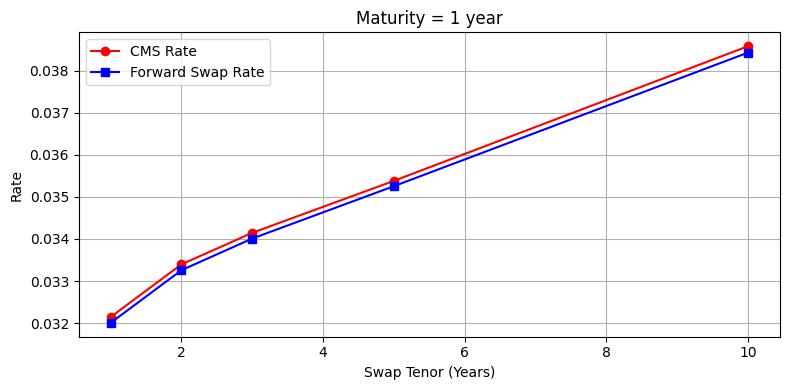

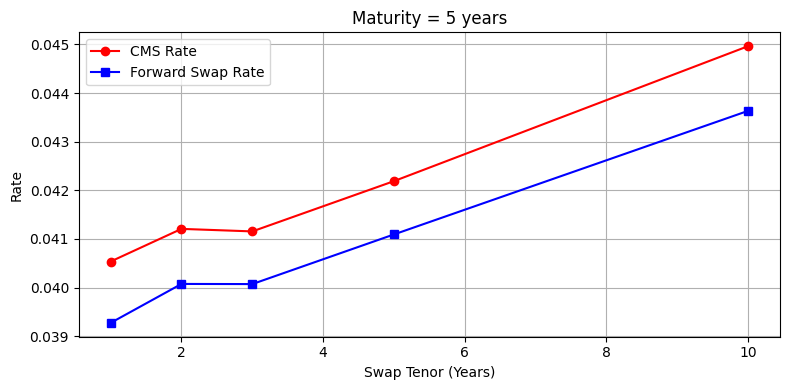

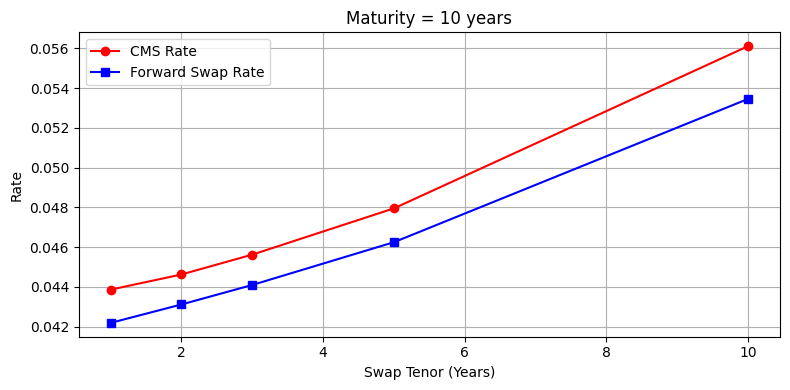

In [18]:
# Plot rates per expiry bucket
for idx, bucket in enumerate(['Maturity = 1 year', 'Maturity = 5 years', 'Maturity = 10 years']):
    start_idx = idx * len(swap_tenors)
    end_idx = (idx+1) * len(swap_tenors)
    plt.figure(figsize=(8,4))
    plt.plot(swap_tenors, df_results["CMS_rate"].iloc[start_idx:end_idx], '-o', color='red', label="CMS Rate")
    plt.plot(swap_tenors, df_results["Forward_Swap_rate"].iloc[start_idx:end_idx], '-s', color='blue', label="Forward Swap Rate")
    plt.title(bucket)
    plt.xlabel("Swap Tenor (Years)")
    plt.ylabel("Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Additional Analysis

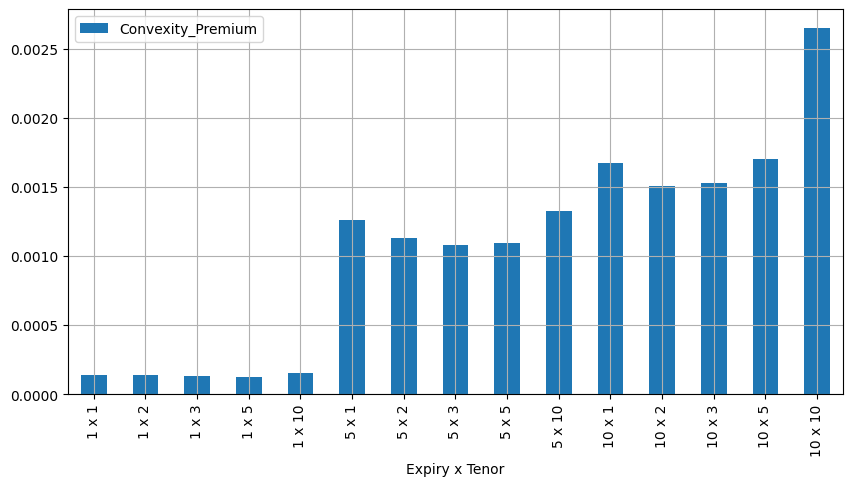

In [19]:
# Plot convexity premium
df_results["Convexity_Premium"] = df_results["CMS_rate"] - df_results["Forward_Swap_rate"]
df_results.plot(x="Expiry x Tenor", y="Convexity_Premium", kind="bar", figsize=(10,5), grid=True)
plt.show()